<a href="https://colab.research.google.com/github/cmannnn/language_classifier/blob/main/language_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Language Classifier

##Imports

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 46.8MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 194kB 58.2MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

##Bing image search

In [3]:
# getting Azure Bing search key and setting it to key
key = os.environ.get('AZURE_SEARCH_KEY', 'a80b54eb571b45658bbad8530262ff7f')

In [4]:
# testing search_images_bing method to see if azure key works
search_images_bing

<function fastbook.search_images_bing>

In [5]:
# using key to search 'grizzly bear' into bing image search
results = search_images_bing(key, 'chinese language')

# grabbing the url's of the results
ims = results.attrgot('content_url')

# checking the length of the URL's
print(f'The number of URL\'s downloaded is: {len(ims)}')

The number of URL's downloaded is: 150


In [6]:
# one random chinese character URL
ims = ['https://thumbs.dreamstime.com/b/chinese-city-tianjin-characters-vector-illustration-151968254.jpg']

# downloading character URL
dest = 'images'
download_url(ims[0], dest)

In [7]:
# mounting Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


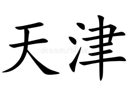

In [8]:
# opening downloaded picture as 128 x 128 rectangle 
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
# creating folder string for each language
language_types = 'korean','arabic','chinese'

# creating a new main folder in our path called 'language'
path = Path('language')

In [10]:
# loop to create new directory with 
if not path.exists():
    path.mkdir()
    for o in language_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} language')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
# verifying there are pictures in the languages directory
fns = get_image_files(path)
fns

(#440) [Path('language/chinese/00000091.jpeg'),Path('language/chinese/00000090.jpg'),Path('language/chinese/00000022.jpg'),Path('language/chinese/00000025.jpg'),Path('language/chinese/00000136.jpg'),Path('language/chinese/00000127.jpg'),Path('language/chinese/00000038.jpg'),Path('language/chinese/00000044.jpg'),Path('language/chinese/00000014.jpg'),Path('language/chinese/00000080.gif')...]

In [12]:
# checking if any images are corrupted
failed = verify_images(fns)
failed

# removing any corrupted files
failed.map(Path.unlink)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#16) [None,None,None,None,None,None,None,None,None,None...]

In [13]:
# creating categorical datablock, identify independent/dependent variables, randomly splitting 20%, 
# using subfolder name as the y value, and resizing the pictures to 128 squares 
languaes = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct = 0.2, seed = 14),
    get_y = parent_label,
    item_tfms = Resize(128))

In [14]:
# defining the images source
dls = languaes.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


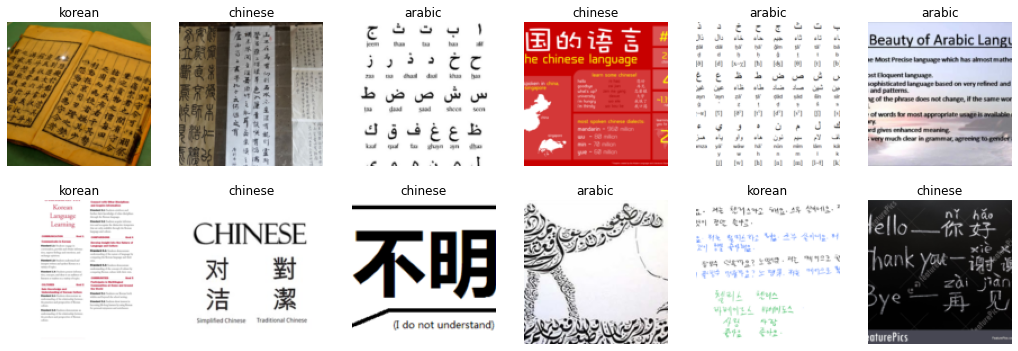

In [15]:
# showing 12 images
dls.valid.show_batch(max_n = 12, nrows = 2)